# Network interpretability of lung X-rays

In this tutorial, we demonstrate visualising network interpretability through a classification task.

The data are a set of X-rays collated from a variety of sources. The labels used are:
- normal (the absence of the following classes)
- pneumonia
- covid

We then use GradCam and occlusion sensitivity to interpret the trained network's classification choices.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/interpretability/covid_classification.ipynb)

In [1]:
try:
    import monai
except ImportError:
    %pip install "monai[tqdm]"

In [2]:
import os
from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from enum import Enum
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import monai
from monai.networks.utils import eval_mode
from monai.networks.nets import Classifier, densenet121
from monai.transforms import (
    Compose, LoadImage, Lambda, AddChannel, 
    ScaleIntensity, ToTensor, RandRotate, 
    RandFlip, Rand2DElastic, RandZoom, Resize,
)

monai.config.print_config()
random_seed = 42
random.seed(random_seed)
monai.utils.set_determinism(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 0.4.0+21.g86c43cf.dirty
Numpy version: 1.19.5
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 86c43cf24f57370fbbc12923d09b0f52e7952cb9

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.0
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
# Unzip data (TODO download if not present)
directory = os.environ.get("MONAI_DATA_DIRECTORY")
directory = tempfile.mkdtemp() if directory is None else directory
data_path=os.path.join(directory, "covid_xray_combined_small")
if not os.path.isdir(data_path):
    data_path_zip=data_path + ".zip"
    if not os.path.isfile(data_path_zip):
        raise RuntimeError("TODO: Download needed.")
    with ZipFile(data_path_zip, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            try:
                zf.extract(member, directory)
            except zipfile.error as e:
                pass

# Load images

In [4]:
crop_size = (320, 320)  # set size of images for network

class Diagnosis(Enum):
    normal = 0
    pneumonia = 1
    covid = 2
num_class = len(Diagnosis)

def get_label(path):
    fname = os.path.basename(path)
    if fname[:6] == "normal":
        return Diagnosis.normal.value
    elif fname[:9] == "pneumonia":
        return Diagnosis.pneumonia.value
    elif fname[:5] == "covid":
        return Diagnosis.covid.value
    else:
        raise RuntimeError(f"Unknown label: {path}")

class CovidImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transforms, even_balance=True):
        
        self.image_files = [j for i in image_dirs for j in glob(i+"/*.png")]
        self.labels = list(map(get_label, self.image_files))
        self.transforms = transforms
        # For even balance, find out which diagnosis has the fewest images
        # and then get that many of each diagnosis
        if even_balance:
            # fewest images of any diagnosis
            num_to_keep = min([self.labels.count(i.value) for i in Diagnosis])
            
            self.image_files = []
            for d in Diagnosis:
                im_files = [j for i in image_dirs for j in glob(f"{i}/{d.name}*.png")]
                random.shuffle(im_files)
                self.image_files += im_files[:num_to_keep]
            random.shuffle(self.image_files)
            self.labels = list(map(get_label, self.image_files))
            
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(lambda im: im if im.ndim==2 else im[...,0]),
    AddChannel(),
    Resize(crop_size,"area"),
    ScaleIntensity(),

    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    Rand2DElastic((0.3,0.3),(1.0,2.0)),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(lambda im: im if im.ndim==2 else im[...,0]),
    AddChannel(),
    Resize(crop_size,"area"),
    ScaleIntensity(),
    ToTensor(),
])

train_dir = os.path.join(data_path,"training")
test1_dir = os.path.join(data_path,"test")
test2_dir = os.path.join(data_path,"test2")
valid_dir = os.path.join(data_path,"validation")

batch_size = 100
# Collate train, test and test1 for the training for more data
train_ds = CovidImageDataset([train_dir, test1_dir, test2_dir], train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)

val_ds = CovidImageDataset([valid_dir], val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=10)

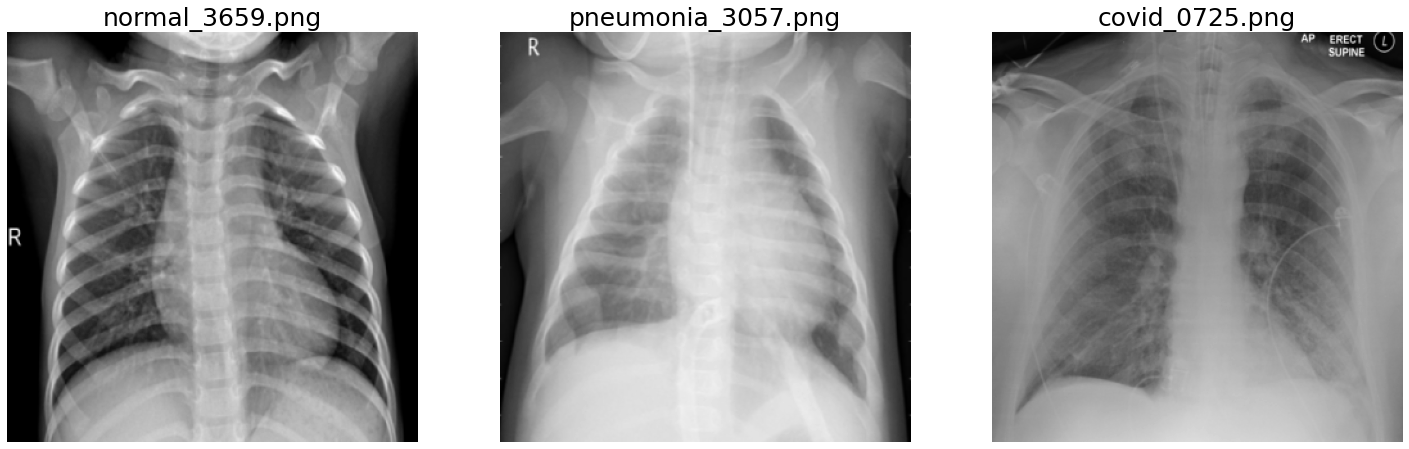

In [5]:
# Display examples
fig, axes = plt.subplots(1,3, figsize=(25,15), facecolor='white')
val_path = os.path.join(data_path,"validation")
for true_label in Diagnosis:
    fname = glob(val_path+"/" + true_label.name + "*.png")
    fname = np.random.choice(fname, size=1)[0]
    im = val_transforms(fname)
    ax = axes[true_label.value]
    im_show = ax.imshow(im[0], cmap='gray')
    ax.set_title(os.path.basename(fname), fontsize=25)
    ax.axis('off')

# Training

In [6]:
def create_new_net():
    return densenet121(
        spatial_dims=2, 
        in_channels=1, 
        out_channels=num_class
    ).to(device)

<IPython.core.display.Javascript object>


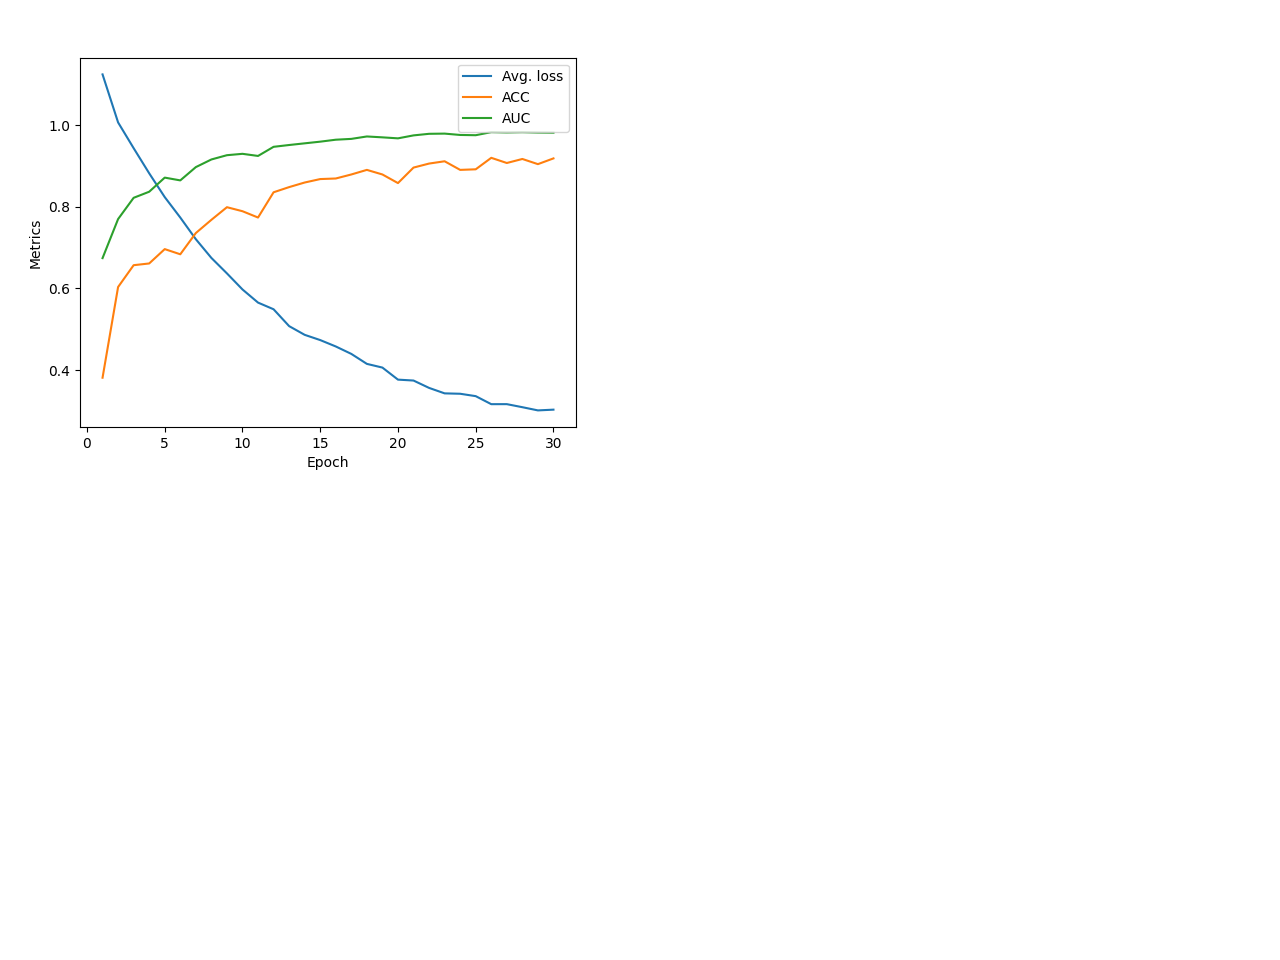

In [7]:
# Switch to notebook plots for live update, switch back at the end
class InteractivePlot(object):
    def __enter__(self):
        %matplotlib notebook
    def __exit__(self, type, value, traceback):
        %matplotlib inline

epoch_num = 30
val_interval = 1
lr = 1e-5
epoch_loss_values = []
auc = []
acc = []
best_acc = -1

net = create_new_net()
net = net.to(device)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr)

with InteractivePlot():
    # Plotting stuff
    fig, ax=plt.subplots(1, 1, facecolor='white')
#     , facecolor='white'
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metrics')
    plt.ion()
    fig.show()
    fig.canvas.draw()


    for epoch in range(epoch_num):
        net.train()
        epoch_loss = 0

        for step, batch_data in enumerate(train_loader):

            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            opt.zero_grad()
            outputs = net(inputs)
            lossval = loss(outputs, labels)
            lossval.backward()
            opt.step()

            epoch_loss += lossval.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(net):
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)

                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device),

                    outputs = net(val_images)
                    y_pred = torch.cat([y_pred, outputs], dim=0)
                    y = torch.cat([y, val_labels], dim=0)

                auc_metric = monai.metrics.compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
                auc.append(auc_metric)

                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                acc.append(acc_metric)

                if acc_metric > best_acc:
                    best_acc = acc_metric
                    torch.save(net.state_dict(), "best_acc_lung_xray_densenet.pth")

        ax.clear()
        train_epochs=np.linspace(1, epoch+1, epoch+1)
        ax.plot(train_epochs, epoch_loss_values, label='Avg. loss')
        val_epochs=np.linspace(1, epoch+1, np.floor((epoch+1)/val_interval).astype(np.int32))
        ax.plot(val_epochs, acc, label='ACC')
        ax.plot(val_epochs, auc, label='AUC')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Metrics')
        ax.legend()
        fig.canvas.draw()

              precision    recall  f1-score   support

      normal       0.94      0.92      0.93       237
   pneumonia       0.96      0.96      0.96       237
       covid       0.95      0.96      0.95       237

    accuracy                           0.95       711
   macro avg       0.95      0.95      0.95       711
weighted avg       0.95      0.95      0.95       711



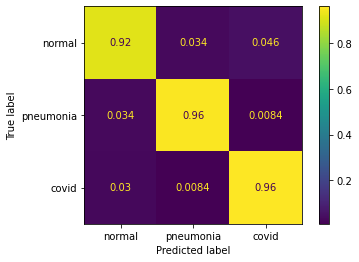

In [8]:
# Load best model
net = create_new_net().to(device)
net.load_state_dict(torch.load("best_acc_lung_xray.pth"))
net.eval()

with eval_mode(net):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(device), val_data[1].to(device),

        outputs = net(val_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(classification_report(
    y.cpu().numpy(), 
    y_pred.cpu().numpy(), 
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(), 
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1]);

# Interpretability

Use GradCAM and occlusion sensitivity for network interpretability.

The occlusion sensitivity returns two images: the sensitivity image and the most probable class.

* Sensitivity image -- how the probability of an inferred class changes as the corresponding part of the image is occluded.
    * Big decreases in the probability imply that that region was important in inferring the given class
    * The output is the same as the input, with an extra dimension of size N appended. Here, N is the number of inferred classes. To then see the sensitivity image of the class we're interested (maybe the true class, maybe the predcited class, maybe anything else), we simply do ``im[...,i]``.
* Most probable class -- if that part of the image is covered up, does the predicted class change, and if so, to what?

In this example the network has been sufficiently trained that the predicted class doesn't change as parts of the image are occluded. However, one can imagine how this feature might be useful when the results are less than satisfactory. 

In [9]:
target_layer = "class_layers.relu"  # for name, _ in net.named_modules(): print(name)

gradcam = monai.visualize.GradCAM(nn_module=net, target_layers=target_layer)
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=net, margin=3, n_batch=batch_size, stride=10)

Computing occlusion sensitivity: 100%|██████████| 1024/1024 [00:01<00:00, 593.48it/s]


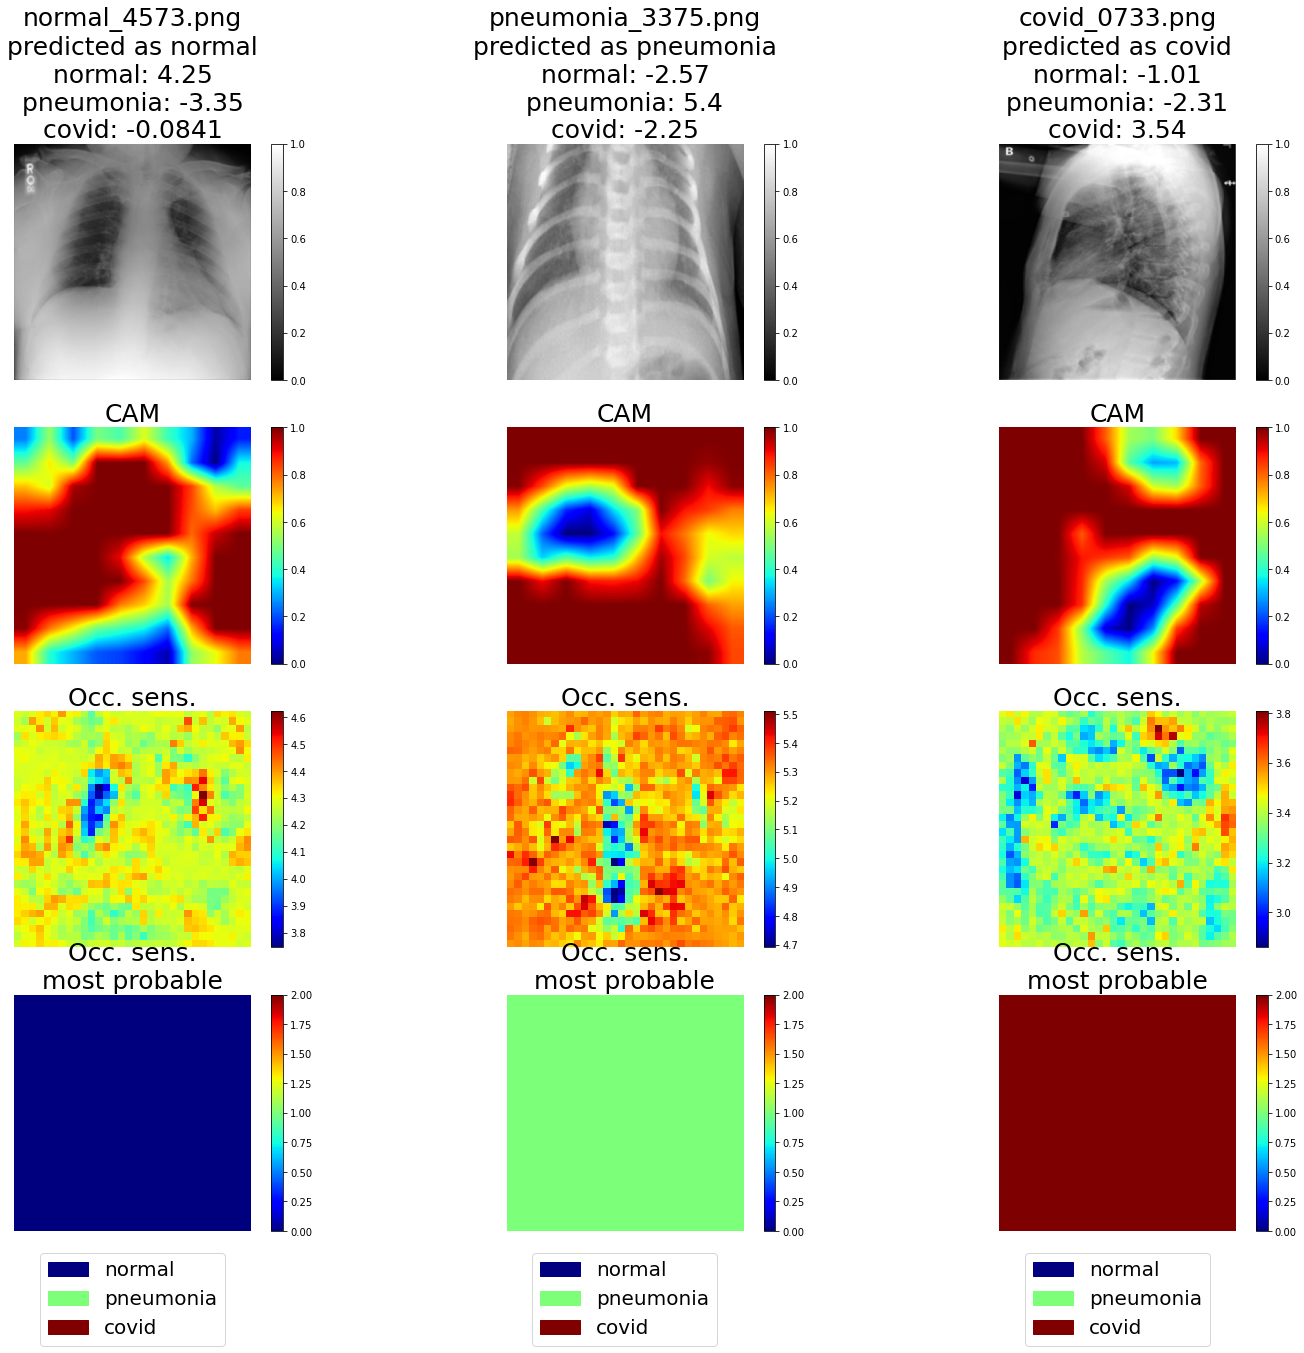

In [10]:
# Display examples
subplot_shape = [4, num_class]
fig, axes = plt.subplots(*subplot_shape, figsize=(25,20), facecolor='white')

for true_label in Diagnosis:
    fnames = glob(val_path+"/" + true_label.name + "*.png")
    random.shuffle(fnames)
    # Find a correctly predicted example
    for fname in fnames:
        img = val_transforms(fname)[None].to(device)
        y_pred = net(img)
        pred_label = Diagnosis(y_pred.argmax(1).item())
        if pred_label == true_label:
            break
    im_title = f"{os.path.basename(fname)}\npredicted as {pred_label.name}"
    for d in Diagnosis:
        im_title += f"\n{d.name}: {y_pred[0,d.value]:.3}"
    
    res_cam = gradcam(x=img, class_idx=true_label.value)
    occ_map, occ_most_prob = occ_sens(x=img)
    occ_map = occ_map[..., true_label.value]
    
    # the rest is for visualisations
    for row, (im, title) in enumerate(zip(
        [img, res_cam, occ_map, occ_most_prob], 
        [im_title, "CAM", "Occ. sens.", "Occ. sens.\nmost probable"],
    )):
        cmap = 'gray' if row == 0 else 'jet'
        col = true_label.value
        ax = axes[row, col]
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu()
        if row != 3:
            im_show = ax.imshow(im[0][0], cmap=cmap)
        else:
            im_show = ax.imshow(im[0][0], cmap=cmap, vmin=0, vmax=num_class-1)
            # for the most probable, need to give the classes in the legend
            handles = [mpatches.Patch(color=im_show.cmap(im_show.norm(d.value)), label=d.name) 
                       for d in Diagnosis]
            ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=20)

        ax.set_title(title, fontsize=25)
        ax.axis('off')
        fig.colorbar(im_show, ax=ax)